# Analyzing Emergence of New Phase

<IPython.core.display.Javascript object>


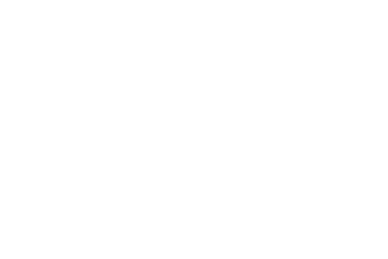

In [16]:
#importing the required modules
import numpy as np #Numerical Python
import scipy #Scientific Python
from scipy.optimize import leastsq #for least-squares fitting
from scipy.ndimage import gaussian_filter as gf
from scipy.signal import blackmanharris as bh #for potentially filtering raw images

%matplotlib notebook

import matplotlib #for plotting and displaying images
from matplotlib import pylab as plt
pylab.gray()

#For making interactive user interfaces (buttons and sliders and such)
#import ipywidgets as widgets
#from ipywidgets import Layout, interact, fixed

#Loading the particle tracking software
import sys
sys.path.append("Z:\\Code\\BeadTracking\\track") #Locate code
import tiff_file #Ignore any warnings importing this may cause

sys.path.append("Z:\Code\ddm")
import ddm_clean as ddm

import numpy.fft
from numpy.fft import fft2, fftshift, fft, ifft2

In [88]:
data_dir = "Z:\\381W\\MF_ML_PHYS_381\\02242019_co_30dex\\03122019_Xanthan\\"
file_name = "2019_03_13_PX16_Zgel002_512x512.tif" #1363 frames

Let's take a look at a couple frames of this movie.

In [89]:
def filterImage(image, filterSize=40):
    gaussFiltered = gf(image, filterSize)
    return 1.0*image - gaussFiltered

<IPython.core.display.Javascript object>


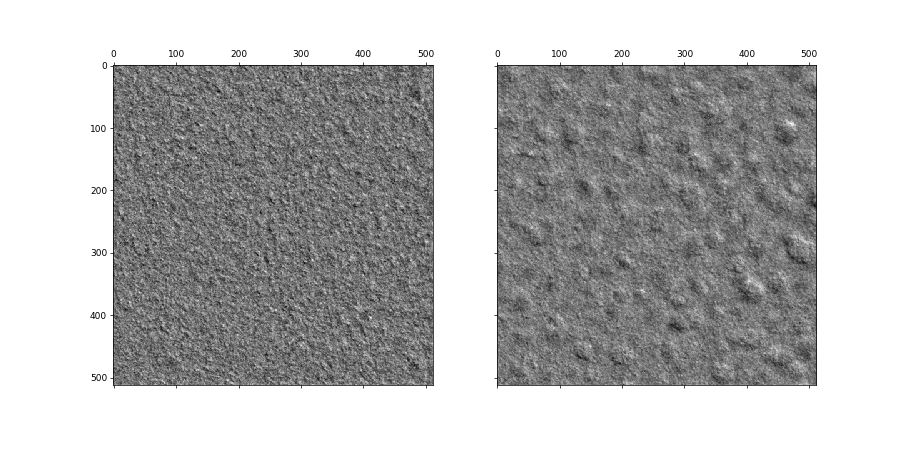

In [90]:
image_0010 = tiff_file.imread(data_dir+file_name, key=10) #10th image in file
image_0400 = tiff_file.imread(data_dir+file_name, key=400) #400th image
image_0600 = tiff_file.imread(data_dir+file_name, key=600) #400th image
fig,ax = plt.subplots(1,2,sharey=True,figsize=(14,7)) #making side-by-side plot (#rows = 1, #columns=2)
ax[0].matshow(filterImage(image_0010)) #On first subplot show frame 10
ax[1].matshow(filterImage(image_0400)) #On second subplot show frame 400

Is there a characteristic feature size in these images? What would you say it is?

In [91]:
image_0010n = filterImage(image_0010, filterSize=20)
image_0400n = filterImage(image_0600, filterSize=20)

#We'll use the Fourier transform to find that characteristic size
fft_im_0010 = abs(fftshift(fft2(image_0010n-image_0010n.mean())))**2 #what does fftshift do?
radial_av_fftim010 = ddm.newRadav(fft_im_0010/(image_0010.shape[0]*image_0010.shape[1]))
fft_im_0400 = abs(fftshift(fft2(image_0400n-image_0400n.mean())))**2
radial_av_fftim400 = ddm.newRadav(fft_im_0400/(image_0400.shape[0]*image_0400.shape[1]))
pixel_scale = 1.0 #Microns per pixel. But for now we'll be in units of pixels so this can be 1
f = np.arange(1,radial_av_fftim010.shape[0]+1)*(1./(image_0010.shape[0]*pixel_scale)) 

<IPython.core.display.Javascript object>


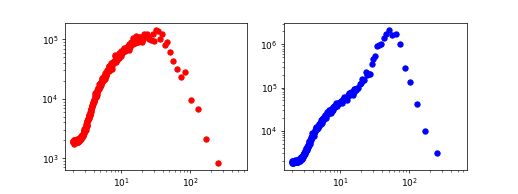

In [92]:
fig,ax = plt.subplots(1,2,figsize=(8,3))
ax[0].loglog(1./f,radial_av_fftim010,'ro')
ax[1].loglog(1./f,radial_av_fftim400,'bo')


It seems that the FT has a peak at a frequency corresponding to about 7 pixels for image 100 and 13 pixels for image 600. 

Let's visually check that. We'll plot the images and overlay a grid with a spacing of that characteristic size.

<IPython.core.display.Javascript object>


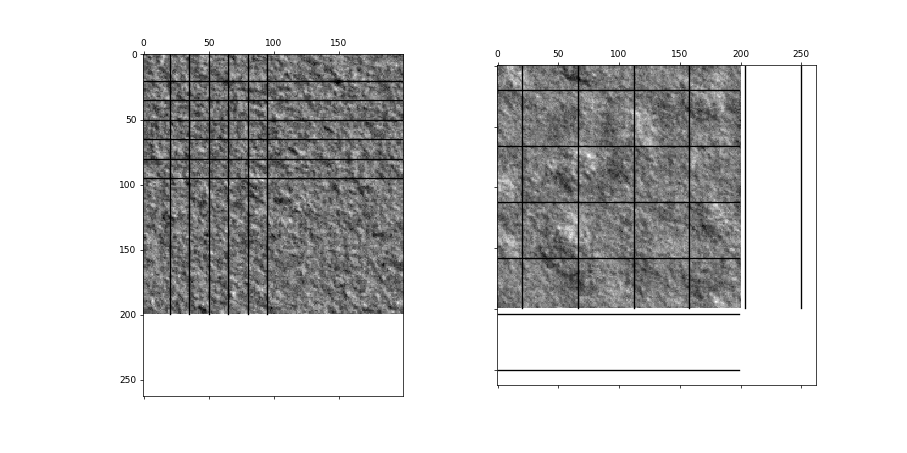

In [93]:
fig,ax = plt.subplots(1,2,sharey=True,figsize=(14,7))

#Crop the images and display
ax[0].matshow(image_0010n[20:220,20:220]) #Just showing a 200x200 pixel region of the image
ax[1].matshow(image_0400n[20:220,20:220])

#From above plot, it seems that characteristic sizes are 7 and 13 pixels, respectively
characteristic_size = [15,46]

for i,axis in enumerate(ax):
    spacing = characteristic_size[i]
    axis.plot(range(200),np.ones((200))*20,'-k'); axis.plot(range(200),np.ones((200))*(20+spacing),'-k');
    axis.plot(range(200),np.ones((200))*(20+2*spacing),'-k'); axis.plot(range(200),np.ones((200))*(20+3*spacing),'-k');
    axis.plot(range(200),np.ones((200))*(20+4*spacing),'-k'); axis.plot(range(200),np.ones((200))*(20+5*spacing),'-k');
    axis.plot(np.ones((200))*20,range(200),'-k'); axis.plot(np.ones((200))*(20+spacing),range(200),'-k');
    axis.plot(np.ones((200))*(20+2*spacing),range(200),'-k'); axis.plot(np.ones((200))*(20+3*spacing),range(200),'-k');
    axis.plot(np.ones((200))*(20+4*spacing),range(200),'-k'); axis.plot(np.ones((200))*(20+5*spacing),range(200),'-k');

In [94]:
#Initialize empty lists to store things in
radial_averages = []
frames = []

pixel_scale = 1.0 #Microns per pixel. But for now we'll be in units of pixels
f = np.arange(1,image_0010.shape[1]/2)*(1./(image_0010.shape[0]*pixel_scale)) 

#this for loop will go from 0 to 1200 in steps of 5 [ie, 0,5,10...]
for i in range(100,600,10): 
    image = filterImage(tiff_file.imread(data_dir+file_name, key=range(i-1,i+2)).mean(axis=0), filterSize=20) #read image i in file
    nx, ny = image.shape #get the dimensions of this image
    fft_im = abs(fftshift(fft2(image-image.mean()))**2)
    radial_av_fftim = ddm.newRadav(fft_im/(nx*ny))
    radial_averages.append(radial_av_fftim)
    frames.append(i)
    

    
#tiff_file.imsave("seq_ffts.tif", np.array(sequence_of_ffts))
#tiff_file.imsave("seq_ffts_logscale.tif", np.array(sequence_of_ffts_log))

rad_av = np.array(radial_averages)
np.save("radial_averages_of_fft.npy", rad_av)

In [95]:
print image_0010[1].shape[0]/2
print rad_av.shape
print f.shape

256
(50L, 255L)
(255L,)


<IPython.core.display.Javascript object>


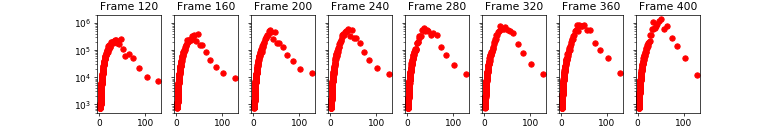

<IPython.core.display.Javascript object>


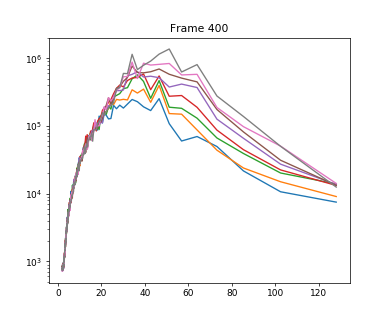

In [96]:
fig,axes = plt.subplots(1,8,sharey=True,figsize=(12,2))
plot_every = 4
for i,ax in enumerate(axes):
    #Plot frequencies from 10th to -20th (20th from the end)
    ax.semilogy(1./f[3:-2],rad_av[(i*plot_every)+2,3:-2],'ro')
    ax.set_title("Frame %i" % frames[(i*plot_every)+2])



fig,ax = plt.subplots(figsize=(6,5))
for i in range(8):
    #Plot frequencies from 10th to -20th (20th from the end)
    ax.semilogy(1./f[3:-2],rad_av[(i*plot_every)+2,3:-2])
    ax.set_title("Frame %i" % frames[(i*plot_every)+2])

Let's find the location of the peak of this functions to determine the characteristic size.

In [97]:
#Make a peaked function (we'll use a Gaussian)
def peakedGauss(params, x):
    '''
    Returns a 1D Gaussian
    '''
    B = params[0] #Noise
    A = params[1] #amplitude
    mu = params[2] #center
    width = params[3]
    expTerm = ((x-mu)/width)**2
    g = B + (A * np.exp(-1*expTerm))
    return g

def errorFunc(params, data, x):
    '''
    Error function for least squares fitting
    '''
    return data-peakedGauss(params,x)

In [102]:
#Let's consider frame 480 since that one looks nice from the plot above
w = np.where(np.array(frames)==480)
radial_av_fft_frameX = rad_av[w[0][0],:]

#Now, where is that peaked. We'll use np.argmax which returns the argument (ie, index) of the maximum of the array
w_peak = np.argmax(radial_av_fft_frameX[2:-2]) + 2 #Doing the [2:-2] thing to get rid of noisy high/low freq data
print "Peak at %i which corresponds to characteristic size of %.2f pixels" % (w_peak, 1.0/f[w_peak])

Peak at 9 which corresponds to characteristic size of 51.20 pixels


Let's examine a little chunk of the radially averaged FT centered around the peak. 
Then we can fit that to a peaked function to more accurately determine the characteristic size.

In [106]:
width_of_fit_region = 9
frequencies = f[w_peak - width_of_fit_region:w_peak + width_of_fit_region]
radial_av_fft_frameX_chunk = radial_av_fft_frameX[w_peak - width_of_fit_region:w_peak + width_of_fit_region]

<IPython.core.display.Javascript object>


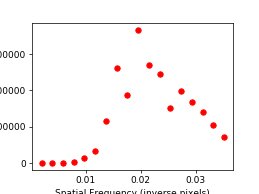

Text(0.5,0,'Spatial Frequency (inverse pixels)')

In [107]:
fig,ax = plt.subplots(figsize=(4,3))
ax.plot(frequencies, radial_av_fft_frameX_chunk, 'ro')
ax.set_xlabel("Spatial Frequency (inverse pixels)")

<IPython.core.display.Javascript object>


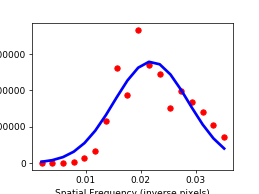

From fit, found characteristic size of 45.68 pixels


In [108]:
#First, establish initial guess parameters for fitting function plotted above to Gaussian
guessNoise = radial_av_fft_frameX_chunk.min()
guessAmplitude = radial_av_fft_frameX_chunk.max() - guessNoise
guessCenter = frequencies[width_of_fit_region]
guessWidth = guessCenter - frequencies[0]
initGuess = np.array([guessNoise, guessAmplitude, guessCenter, guessWidth])

#Now, do the fit
fit,flag = leastsq(errorFunc, initGuess, args=(radial_av_fft_frameX_chunk, frequencies))

#Plot result
fig,ax = plt.subplots(figsize=(4,3))
ax.plot(frequencies, radial_av_fft_frameX_chunk, 'ro')
ax.plot(frequencies, peakedGauss(fit,frequencies), '-b',lw=3)
ax.set_xlabel("Spatial Frequency (inverse pixels)")
print "From fit, found characteristic size of %.2f pixels" % (1./fit[2])

Now we just have to do this for *all* frames (or at least all the frames we calculated the FT).

Before we do that. Let's just make some quick little helper functions. 

In [109]:
def returnChunk(radialAvgFT, frequencies, chunk_width=10):
    w_peak = np.argmax(radialAvgFT[10:-10])+10
    #print w_peak
    return radialAvgFT[w_peak-chunk_width:w_peak+chunk_width], frequencies[w_peak-chunk_width:w_peak+chunk_width]

def returnBestGuessParams(littleChunk, frequencies):
    guessNoise = littleChunk.min()
    guessAmplitude = littleChunk.max()-guessNoise
    guessCenter = frequencies[int(len(frequencies)/2.0)]
    guessWidth = guessCenter - frequencies[0]
    return np.array([guessNoise, guessAmplitude, guessCenter, guessWidth])

In [110]:
charSize = [] #characterisitic size
framesUsed = [] #corresponding frame
for i,radialAvgs in enumerate(rad_av):
    #skip first 12 because hard to detect distinct domains in early times
    if i>5:
        chunkRadAv, chunkFreq = returnChunk(radialAvgs, f)
        initGuess = returnBestGuessParams(chunkRadAv, chunkFreq)
        fit,flag = leastsq(errorFunc, initGuess, args=(chunkRadAv,chunkFreq))
        charSize.append(1./fit[2])
        framesUsed.append(frames[i])
charSize = np.array(charSize)
framesUsed = np.array(framesUsed)

<IPython.core.display.Javascript object>


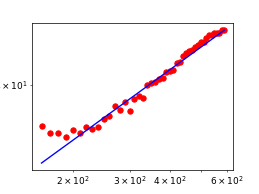

In [119]:
#Check for power law dynamics of growth of the characteristic size of domains
fig,ax = plt.subplots(figsize=(4,3))
ax.loglog(framesUsed, charSize,'ro')
ax.loglog(framesUsed, 5.7*(framesUsed**(1./3)),'-b')